In [0]:
%tensorflow_version 2.x 

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D, Input
from tensorflow.keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D

from tensorflow.keras.utils import to_categorical

## Getting Data

Get ner_dataset.csv from https://www.kaggle.com/abhinavwalia95/how-to-loading-and-fitting-dataset-to-scikit/data

In [0]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill") 

In [0]:
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


Data Pre-Processing

In [0]:
words = list(set(data["Word"].values))
words.append("ENDPAD")

In [0]:
n_words = len(words)
n_words

35179

In [0]:
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags

17

In [0]:
tags

['B-org',
 'I-per',
 'I-nat',
 'B-geo',
 'B-nat',
 'B-art',
 'B-eve',
 'I-gpe',
 'O',
 'B-gpe',
 'I-art',
 'B-tim',
 'I-eve',
 'B-per',
 'I-org',
 'I-geo',
 'I-tim']

Now we have 47,959 sentences (total number of sentences from ner_dataset.csv) that contains 35,178 different words and tagged by 17 tags.

We write SentenceGetter class to retrieve sentences with their words, POS and tags from the datasets. The code is taken from https://www.depends-on-the-definition.com/named-entity-recognition-conditional-random-fields-python/

In [0]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        # A lambda function can take any number of arguments, but can only have one expression.
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

This is how a sentence looks.

In [0]:
getter = SentenceGetter(data)
sentences = getter.sentences
sentences[:2]

[[('Thousands', 'NNS', 'O'),
  ('of', 'IN', 'O'),
  ('demonstrators', 'NNS', 'O'),
  ('have', 'VBP', 'O'),
  ('marched', 'VBN', 'O'),
  ('through', 'IN', 'O'),
  ('London', 'NNP', 'B-geo'),
  ('to', 'TO', 'O'),
  ('protest', 'VB', 'O'),
  ('the', 'DT', 'O'),
  ('war', 'NN', 'O'),
  ('in', 'IN', 'O'),
  ('Iraq', 'NNP', 'B-geo'),
  ('and', 'CC', 'O'),
  ('demand', 'VB', 'O'),
  ('the', 'DT', 'O'),
  ('withdrawal', 'NN', 'O'),
  ('of', 'IN', 'O'),
  ('British', 'JJ', 'B-gpe'),
  ('troops', 'NNS', 'O'),
  ('from', 'IN', 'O'),
  ('that', 'DT', 'O'),
  ('country', 'NN', 'O'),
  ('.', '.', 'O')],
 [('Iranian', 'JJ', 'B-gpe'),
  ('officials', 'NNS', 'O'),
  ('say', 'VBP', 'O'),
  ('they', 'PRP', 'O'),
  ('expect', 'VBP', 'O'),
  ('to', 'TO', 'O'),
  ('get', 'VB', 'O'),
  ('access', 'NN', 'O'),
  ('to', 'TO', 'O'),
  ('sealed', 'JJ', 'O'),
  ('sensitive', 'JJ', 'O'),
  ('parts', 'NNS', 'O'),
  ('of', 'IN', 'O'),
  ('the', 'DT', 'O'),
  ('plant', 'NN', 'O'),
  ('Wednesday', 'NNP', 'B-tim'),
  ('

In [0]:
len(sentences)

47959

## Features Extraction on Sentences

Create the following helpers for features extraction

In [0]:
max_len = 50

word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

idx2word = {i: w for w, i in word2idx.items()}
idx2tag = {i: w for w, i in tag2idx.items()}

Convert sentences to numbers

In [0]:
X = [[word2idx[w[0]] for w in s] for s in sentences]

In [0]:
print(X[0])

[6090, 34201, 21052, 6083, 23035, 18687, 30668, 32014, 13938, 15347, 24611, 26086, 3771, 232, 175, 15347, 672, 34201, 9655, 8851, 18482, 14231, 1630, 25956]


In [0]:
for i in X[0]:
  print(idx2word[i],end= " ") 

Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country . 

In [0]:
idx2word[n_words-1]

'ENDPAD'

Padding the sentences 

In [0]:
# value = n-words-1 which is 'ENDPAD'or index 35178
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words - 1)

In [0]:
X[0]

array([ 6090, 34201, 21052,  6083, 23035, 18687, 30668, 32014, 13938,
       15347, 24611, 26086,  3771,   232,   175, 15347,   672, 34201,
        9655,  8851, 18482, 14231,  1630, 25956, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178], dtype=int32)

## Labels

Convert labels (tags) to numbers

In [0]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]

In [0]:
print(y[0])

[8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 9, 8, 8, 8, 8, 8]


In [0]:
for i in y[0]:
  print(idx2tag[i],end= " ") 

O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O 

In [0]:
tag2idx["O"]

8

Padding the labels

In [0]:
# max_len = 50
# value = 11 (O – Outside any chunk)
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [0]:
y[0]

array([8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 9, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8], dtype=int32)

In [0]:
y[0].shape

(50,)

In [0]:
y[1], X[1]

(array([ 9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 11,  8,
         8,  8,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8],
       dtype=int32),
 array([22173,  6458, 12542,  1661,  7401, 32014, 24094, 12401, 32014,
        31676, 18435,  2016, 34201, 15347, 25684, 24817,  1300, 17980,
        19115, 23974,  9624,   792,  3174,  9422, 25956, 35178, 35178,
        35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
        35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
        35178, 35178, 35178, 35178, 35178], dtype=int32))

Perform One-Hot Encoding for labels

In [0]:
# One hot encoding
# n_tags = 17
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [0]:
y[0].shape

(50, 17)

In [0]:
print(y[0])

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.

## Split Train and Test Sets

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [0]:
X_train.shape, X_test.shape

((43163, 50), (4796, 50))

In [0]:
len(y_train), len(y_test)

(43163, 4796)

## Create and Compile Model

In [0]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(input)
model = Dropout(0.5)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  

In [0]:
model = Model(input, out)

In [0]:
opt = tf.keras.optimizers.Adam(lr=0.01, decay=1e-6)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])          

In [0]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 50)            1758950   
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 200)           120800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


## Training

In [0]:
history = model.fit(X_train, np.array(y_train), 
                    batch_size=32, 
                    epochs=10, 
                    validation_split=0.2,
                    verbose=1)

Epoch 1/10
1080/1080 [==============================] - 356s 329ms/step - loss: 0.0878 - accuracy: 0.9762 - val_loss: 0.0486 - val_accuracy: 0.9856
Epoch 2/10
1080/1080 [==============================] - 361s 335ms/step - loss: 0.0447 - accuracy: 0.9864 - val_loss: 0.0462 - val_accuracy: 0.9862
Epoch 3/10
1080/1080 [==============================] - 351s 325ms/step - loss: 0.0388 - accuracy: 0.9882 - val_loss: 0.0458 - val_accuracy: 0.9863
Epoch 4/10
1080/1080 [==============================] - 355s 329ms/step - loss: 0.0360 - accuracy: 0.9887 - val_loss: 0.0468 - val_accuracy: 0.9863
Epoch 5/10
1080/1080 [==============================] - 360s 333ms/step - loss: 0.0345 - accuracy: 0.9892 - val_loss: 0.0484 - val_accuracy: 0.9856
Epoch 6/10
1080/1080 [==============================] - 358s 332ms/step - loss: 0.0337 - accuracy: 0.9894 - val_loss: 0.0475 - val_accuracy: 0.9862
Epoch 7/10
1080/1080 [==============================] - 362s 336ms/step - loss: 0.0331 - accuracy: 0.9895 - val_

## Plot Accuracy and Loss

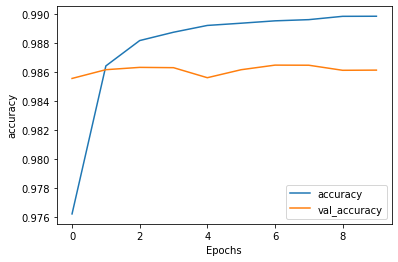

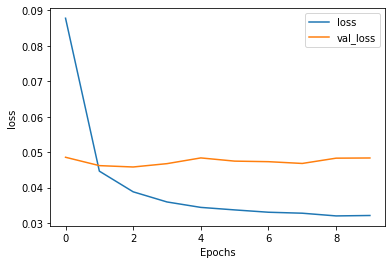

In [0]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Prediction

In [0]:
i = 1586
p = model.predict(np.array([X_test[i]]))

p = np.argmax(p, axis=-1)


print("{:15} {:5}".format("Word",  "Pred"))
for w, pred in zip(X_test[i], p[0]):
    print("{:15}: {}".format(words[w], tags[pred]))

Word            (True ): Pred
The            : O
accident       : O
happened       : O
Saturday       : B-tim
morning        : I-tim
in             : O
the            : O
town           : O
of             : O
Aweil          : B-geo
,              : O
800            : O
kilometers     : O
southwest      : O
of             : O
Khartoum       : B-geo
.              : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
